In [11]:
# 导入需要使用的库,其中numpy是支持数组和矩阵运算的科学计算库,而matplotlib是绘图库
import numpy as np
import matplotlib.pyplot as plt


class BernoulliBandit:
    """伯努利多臂老虎机(拉杆输出结果集仅为{0,1})"""

    def __init__(self, K):
        """
        初始化K臂伯努利老虎机
        :param K: 输入K表示K个拉杆
        """

        # np.random.uniform 均匀分布，默认 low=0.0, high=1.0
        self.probs = np.random.uniform(size=K) # 随机生成K个0～1的数,作为拉动{0,1...K}每根拉杆的获奖概率
        self.best_idx = np.argmax(self.probs)  # 获奖概率最大的拉杆位置 best_idx
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率（即 best_idx 的获奖概率）
        self.K = K # 拉杆数量

    def step(self, k):
        """
        返回奖励：拉动第k号拉杆后，返回奖励
        :param k: 输入k表示选择拉动第k号拉杆
        :return: 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未获奖）
        """
        if np.random.rand() < self.probs[k]:
            return 1 # 获奖
        else:
            return 0 # 未获奖


np.random.seed(1)  # 设定随机种子,使实验具有可重复性
K = 10
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
      (bandit_10_arm.best_idx, bandit_10_arm.best_prob))

# 随机生成了一个10臂伯努利老虎机
# 获奖概率最大的拉杆为1号,其获奖概率为0.7203

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203


In [12]:
class Solver:
    """ 多臂老虎机算法基本框架 """
    def __init__(self, bandit):
        self.bandit = bandit # 使用的多臂老虎机对象
        self.counts = np.zeros(self.bandit.K)  # 初始化一个长度为K的数组，用于保存{0,1...K}每根拉杆的尝试次数
        self.regret = 0.  # 当前步的累积懊悔
        self.actions = []  # 维护一个列表,记录每一步的动作(拉动的拉杆编号)
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔

    def update_regret(self, k):
        """
        为了更加直观、方便地观察拉动一根拉杆的期望奖励离最优拉杆期望奖励的差距，我们引入懊悔（regret）概念.【打开上帝视角】
        """
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        # 运行一定次数,num_steps 为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1 # 在对应拉杆 k 的次数上加1
            self.actions.append(k)
            self.update_regret(k)

In [13]:
class EpsilonGreedy(Solver):
    """ epsilon贪婪算法,继承Solver类 """
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        #初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        """
        执行一步 epsilon-贪婪 算法
        :return: 返回本次动作选择哪一根拉杆
        """
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆
        else:
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
        r = self.bandit.step(k)  # 得到本次动作的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k]) # 按公式，更新期望奖励估值
        return k

epsilon-贪婪算法的累积懊悔为： 25.526630933945313


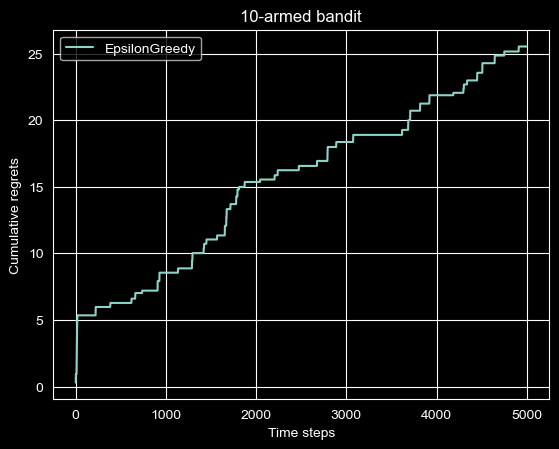

In [14]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d-armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()


np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

# epsilon-贪婪算法的累积懊悔为：25.526630933945313

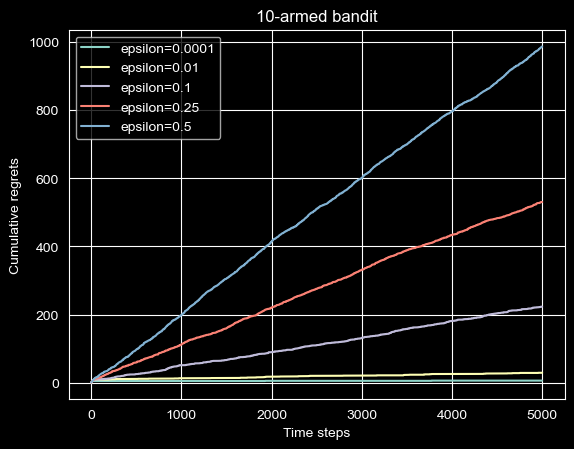

In [15]:
np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
    EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons
]
epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)

epsilon值衰减的贪婪算法的累积懊悔为： 10.114334931260183


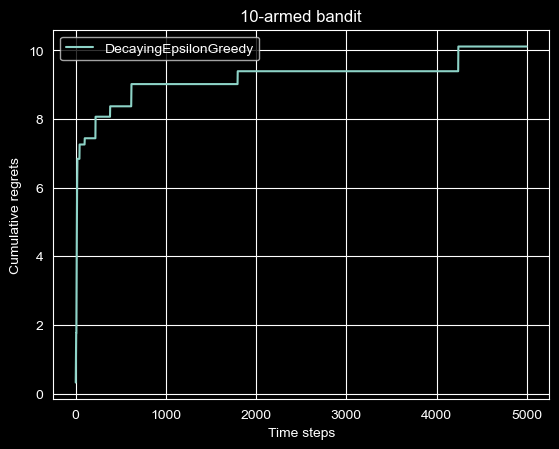

In [16]:
class DecayingEpsilonGreedy(Solver):
    """
    epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类
    epsilon=1/t
    """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减, epsilon=1/t
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r -
                                                          self.estimates[k])

        return k

np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

# epsilon值衰减的贪婪算法的累积懊悔为：10.114334931260183

上置信界算法的累积懊悔为： 70.45281214197854


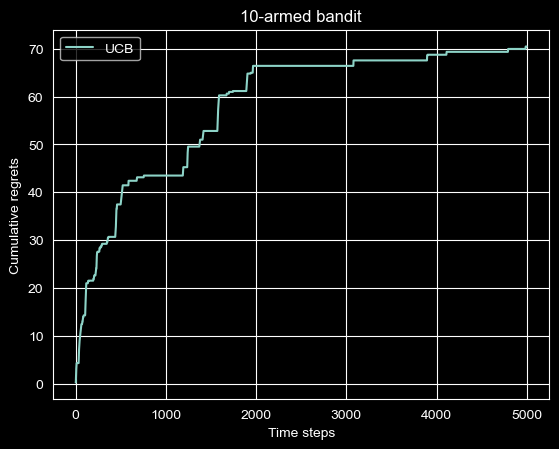

In [17]:
class UCB(Solver):
    """ UCB算法,继承Solver类 """
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB, self).__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef * np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1)))  # 计算上置信界
        k = np.argmax(ucb)  # 选出上置信界最大的拉杆
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r -
                                                          self.estimates[k])
        return k


np.random.seed(1)
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_10_arm, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

# 上置信界算法的累积懊悔为： 70.45281214197854

汤普森采样算法的累积懊悔为： 57.19161964443925


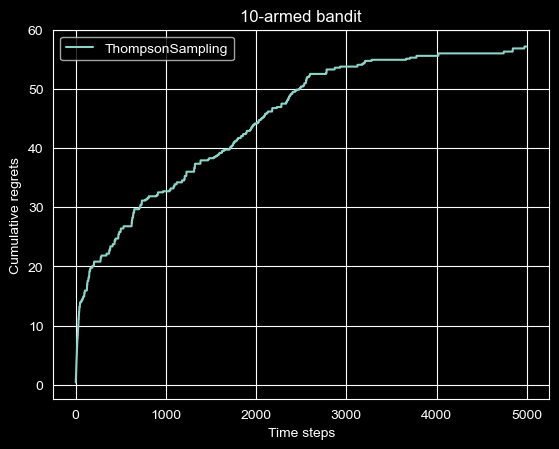

In [18]:
class ThompsonSampling(Solver):
    """ 汤普森采样算法,继承Solver类 """
    def __init__(self, bandit):
        super(ThompsonSampling, self).__init__(bandit)
        self._a = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为1的次数
        self._b = np.ones(self.bandit.K)  # 列表,表示每根拉杆奖励为0的次数

    def run_one_step(self):
        samples = np.random.beta(self._a, self._b)  # 按照Beta分布采样一组奖励样本
        k = np.argmax(samples)  # 选出采样奖励最大的拉杆
        r = self.bandit.step(k)

        self._a[k] += r  # 更新Beta分布的第一个参数
        self._b[k] += (1 - r)  # 更新Beta分布的第二个参数
        return k


np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_10_arm)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

# 汤普森采样算法的累积懊悔为：57.19161964443925

随机生成了一个10臂伯努利老虎机
获奖概率最大的拉杆为1号,其获奖概率为0.7203
epsilon值衰减的贪婪算法的累积懊悔为： 10.114334931260183
上置信界算法的累积懊悔为： 70.45281214197854
汤普森采样算法的累积懊悔为： 57.19161964443925


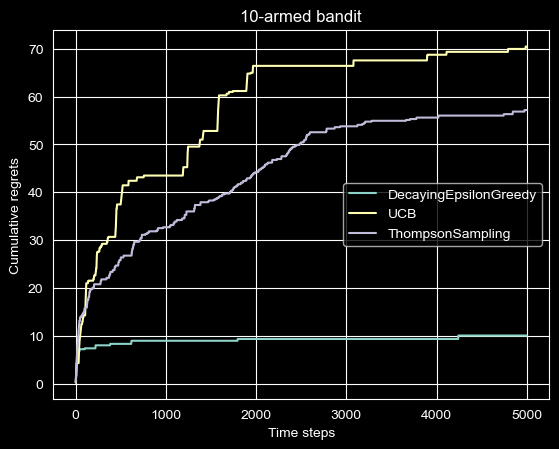

In [19]:
# fluckyeli 新增: 三个次线性增长的算法在更复杂环境上的对比

np.random.seed(1) # 设定随机种子,使实验具有可重复性
K = 10 # 超参数： K 臂老虎机
time_steps = 5000 # 超参数： 拉杆动作次数
bandit_K_arm = BernoulliBandit(K) # 生成 K 臂伯努利老虎机
print("随机生成了一个%d臂伯努利老虎机" % K)
print("获奖概率最大的拉杆为%d号,其获奖概率为%.4f" %
      (bandit_K_arm.best_idx, bandit_K_arm.best_prob))

np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_K_arm)
decaying_epsilon_greedy_solver.run(time_steps)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)

np.random.seed(1)
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bandit_K_arm, coef)
UCB_solver.run(time_steps)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)

np.random.seed(1)
thompson_sampling_solver = ThompsonSampling(bandit_K_arm)
thompson_sampling_solver.run(time_steps)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)

plot_results([decaying_epsilon_greedy_solver,UCB_solver,thompson_sampling_solver], ["DecayingEpsilonGreedy","UCB","ThompsonSampling"])
